In [42]:
import skysurvey
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats


In [2]:
snia = skysurvey.SNeIa()

In [76]:
data = snia.draw(size=10_000, inplace=True)

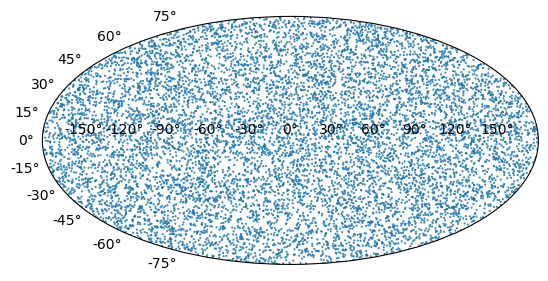

In [77]:
fig = plt.figure()
ax = fig.add_subplot(projection="mollweide")
ax.scatter(
    (data["ra"] - 360 * (data["ra"] > 180)) * np.pi / 180,
    data["dec"] * np.pi / 180,
    linestyle="",
    marker=".",
    s=1,
)

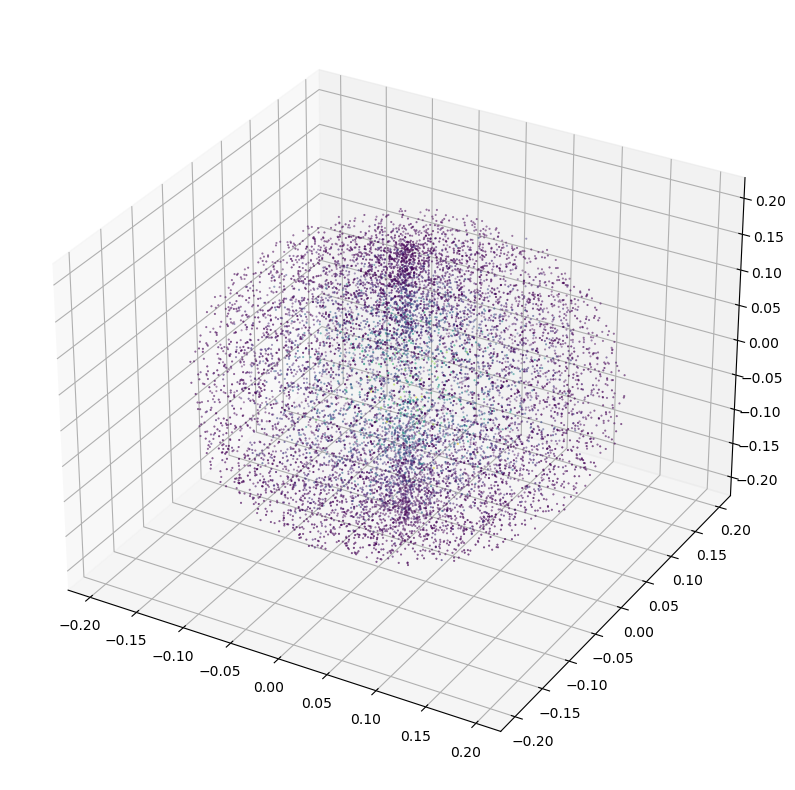

In [78]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(projection="3d"))

from scipy.ndimage import gaussian_filter
from scipy.spatial import cKDTree

count, bin = np.histogramdd([data["ra"], data["dec"], data["z"]], bins=50)
count = gaussian_filter(count, 0.9)
binra, bindec, binz = bin
x, y, z = np.meshgrid(
    (binra[:-1] + binra[1:]) / 2 - binra.min(),
    (bindec[:-1] + bindec[1:]) / 2 - bindec.min(),
    (binz[:-1] + binz[1:]) / 2 - binz.min(),
)
tree = cKDTree(np.dstack((x.flatten(), y.flatten(), z.flatten())).reshape(-1, 3))
pts = np.vstack(
    [data["ra"] - binra.min(), data["dec"] - bindec.min(), data["z"] - binz.min()]
).T


def density_posterior(
    candidates: np.ndarray, tree: cKDTree, density: np.ndarray, k=1
) -> np.ndarray:
    try:
        dist_id, nn_id = tree.query(candidates, k=k)
    except u.UnitConversionError:
        dist_id, nn_id = tree.query(candidates.value, k=k)
    try:
        density = np.average(density[nn_id], axis=1, weights=1 / dist_id)
    except np.AxisError:
        density = density[nn_id]
    return density


c = density_posterior(
    pts, tree, np.transpose(count, axes=[1, 0, 2]).flatten()[::-1], k=1
)

ax.scatter(
    np.cos(data["ra"]) * np.sin(data["dec"]) * data["z"],
    np.sin(data["ra"]) * np.sin(data["dec"]) * data["z"],
    np.cos(data["dec"]) * data["z"],
    s=1,
    c=c,
    marker=".",
)

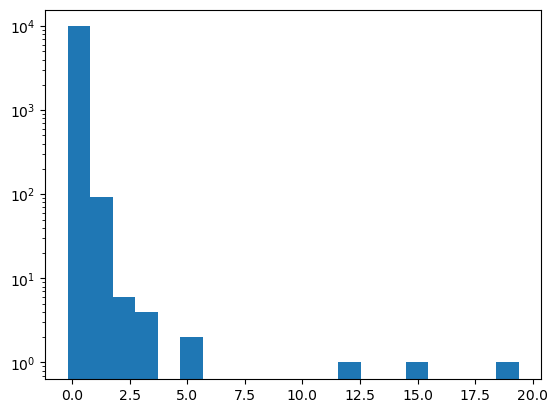

In [84]:
_=plt.hist(data['c'], bins=20, log=True)

In [80]:
snia.model

{'redshift': {'kwargs': {'zmax': 0.2}, 'as': 'z'},
 'x1': {'func': <function SNeIaStretch.nicolas2021 at 0x7f1c212ca8c0>},
 'c': {'func': <function SNeIaColor.color_rvs at 0x7f1c212c9e10>},
 't0': {'func': <built-in method uniform of numpy.random.mtrand.RandomState object at 0x7f1cb818e640>,
        'kwargs': {'low': 56000, 'high': 56200}},
 'magabs': {'func': <function SNeIaMagnitude.tripp1998 at 0x7f1c212ca950>,
            'kwargs': {'x1': '@x1', 'c': '@c', 'mabs': -19.3, 'sigmaint': 0.1}},
 'magobs': {'func': 'magabs_to_magobs',
            'kwargs': {'z': '@z', 'magabs': '@magabs'}},
 'x0': {'func': 'magobs_to_amplitude',
        'kwargs': {'magobs': '@magobs', 'param_name': 'x0'}},
 'radec': {'func': <function random_radec at 0x7f1c2210b2e0>,
           'kwargs': {},
           'as': ['ra', 'dec']},
 'mwebv': {'func': <function get_mwebv at 0x7f1c212c9fc0>,
           'kwargs': {'ra': '@ra', 'dec': '@dec'}}}

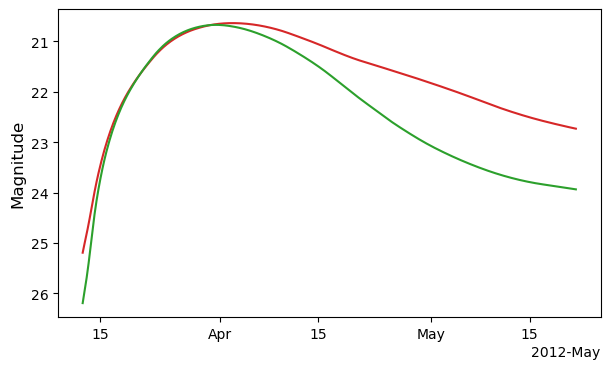

In [82]:
band = ["ztfr", "ztfg"]
fig = snia.show_lightcurve(band, index=9, in_mag=True)

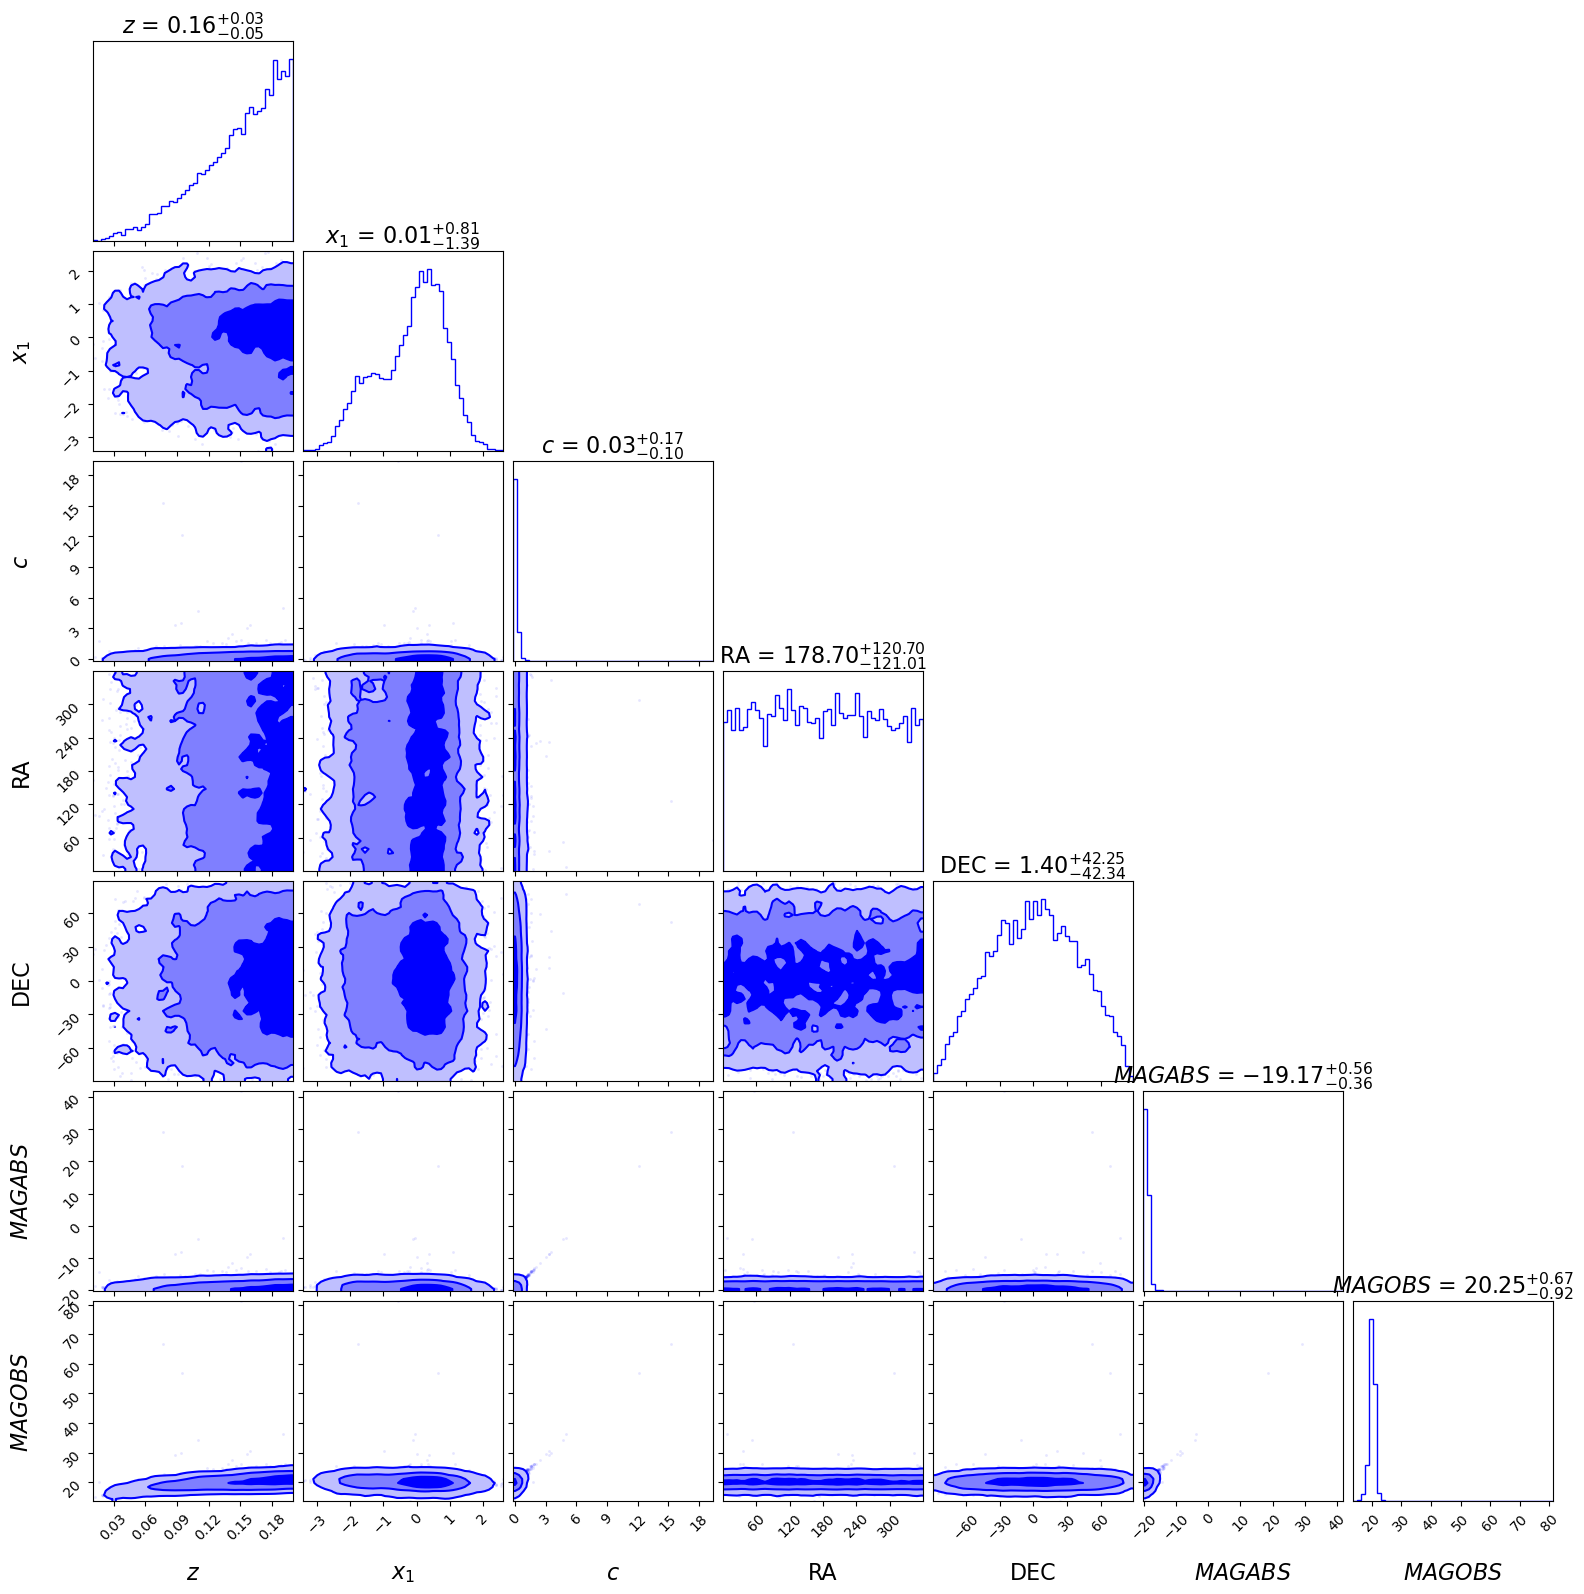

In [83]:
import corner

_=corner.corner(
    data,
    var_names=["z", "x1", "c", "ra", "dec", "magabs", "magobs"],
    show_titles=True,
    bins=50,
    smooth=0.9,
    label_kwargs=dict(fontsize=16),
    title_kwargs=dict(fontsize=16),
    color="b",
    levels=(1 - np.exp(-0.5), 1 - np.exp(-2), 1 - np.exp(-9 / 2.0)),
    plot_density=False,
    plot_datapoints=True,
    fill_contours=True,
    max_n_ticks=7,
    hist_kwargs=dict(density=True, color="b"),
    labels=[r"$z$", r"$x_1$", r"$c$", r"RA", r"DEC", r"$MAGABS$", r"$MAGOBS$"],
    alpha=0.2,
)

In [85]:
data[data["magobs"] == data["magobs"].max()]

,z,x1,c,t0,ra,dec,magabs,mwebv,magobs,x0,template
2463,0.15085,-0.545,19.378796,56080.996094,56.146275,-26.007603,41.845558,0.016603,81.196068,5.274946e-29,salt2


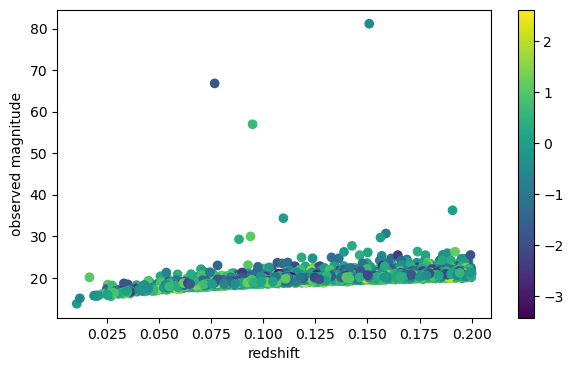

In [87]:
fig = snia.show_scatter("z", "magobs", ckey="x1")
ax = fig.axes[0]

_ = ax.set_ylabel("observed magnitude")
_ = ax.set_xlabel("redshift")

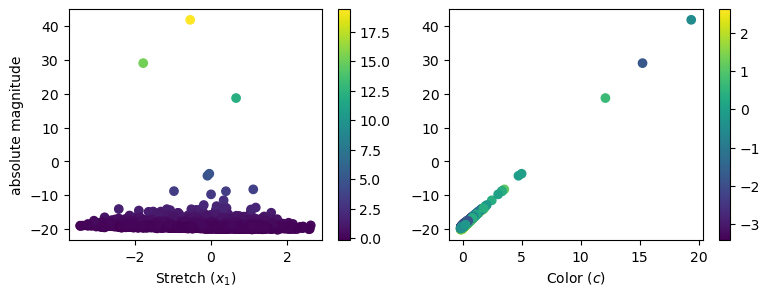

In [88]:
fig = plt.figure(figsize=[9,3])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)

_ = snia.show_scatter("x1", "magabs", ckey="c", ax=ax1) 
_ = snia.show_scatter("c", "magabs", ckey="x1", ax=ax2) 

_ = ax1.set_ylabel("absolute magnitude")
_ = ax1.set_xlabel(fr"Stretch ($x_1$)")
_ = ax2.set_xlabel(fr"Color ($c$)")